# Charge analysis - исследование чарджей
___

**Цель исследования** - изучить данные о замороженных фродерах в категории charge. Попытаемся узнать особенности фродеров и что может быть общего в их поведении, чтобы в будущем предотвратить риски.

В нашем распоряжении есть данные о блокировках пользователей в период **с 2023-09-16 по 2024-09-16**, где указаны такие данные, как дата блокировки, айди юзера, категория, с которой был заморожен пользователь и валюта пользователя.

**План исследования:**
1) Предобработка данных

2) Исследовательский анализ

3) Вывод

## Предобработка
___

В этом разделе импортируем библиотеки и загрузим необходимые данные. Далее подготовим их, чтобы они стали более "чистыми" для анализа. Вероятно, придется загружать дополнительные данные, но для начала рассмотрим данные о заморозке из таблицы folex_locked.

**План:**

1) Убираем ненужные столбцы, пропущенные данные, приведем тип данных для дат

2) Приводим названия категорий к одинаковым и срезаем датафрейм

3) Избавимся от дубликатов

4) Выгружаем список айди и добавим из базы новые данные с пополнениями

In [1]:
# импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

### Замороженные пользователи

In [2]:
df = pd.read_csv('folex_locked_202409171824.csv') #данные выгружены за период с 2023-09-16 по 2024-09-16

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323097 entries, 0 to 323096
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date_block  323097 non-null  object
 1   user_id     323097 non-null  int64 
 2   category    323097 non-null  object
 3   code        320859 non-null  object
 4   project     323097 non-null  object
 5   created_at  323097 non-null  object
 6   updated_at  323097 non-null  object
dtypes: int64(1), object(6)
memory usage: 17.3+ MB


Итак, имеем 323097 строк: избавимся от лишних данных и подготовим данные к анализу.

In [3]:
df.drop(df.columns[[4, 5, 6]], axis=1 , inplace=True) #убираем ненужные столбцы

df['date_block'] = pd.to_datetime(df['date_block'], format='%Y-%m-%d %H:%M:%S') #изменим тип данных для дат

df.sort_values('date_block', ascending=True).head()

,date_block,user_id,category,code
15895,2023-09-16 21:00:00,13182863,Кардер,PLN
16128,2023-09-16 21:00:00,123211189,Послегольщик,UAH
16127,2023-09-16 21:00:00,123210431,Чипдампинг,BDT
16126,2023-09-16 21:00:00,123209941,Чипдампинг,BDT
16125,2023-09-16 21:00:00,123208947,Кардер,EUR


In [4]:
df.isna().sum() #посмотрим пропущенные данные

date_block       0
user_id          0
category         0
code          2238
dtype: int64

In [5]:
#количество пропущенных данных ничтожно мало по отношению ко всему массиву, так что избавимся от них
df = df.dropna()

In [6]:
df['category'].unique()

array(['Кардер', 'Послегольщик', 'Фин. фрод', 'Чипдампинг', 'Bonushunter',
       'Charge', 'Фрод MBC', 'Valui', 'Фрод от Рефовода',
       'Взлом аккаунта', 'Фрод от партнера', 'Professional', 'Фин. фрод ',
       'Вилочник', 'Тимплей', 'Проданный аккаунт', 'Казино', 'Бот',
       'Бонусхантер', 'fin', 'Chipdumping', 'Casino', 'Fin fraud',
       'Poslegol', 'Vzlom account', 'Carder', 'MBC', 'Bot', 'Инсайдер',
       'Vilki ', 'Bot ', 'Vilki', 'carder', 'FraudFromRef',
       'Послегольщик ', 'Chimp', 'poslegol', 'Профи', 'Poslegol ',
       'Prodan account', 'vzlom', 'Fraud from Referal', 'FIN', 'Chip ',
       'chimp', 'Insider', ' FraudFromRef', 'charge ', 'Fraud MBC',
       'charge', 'fraudFromPartner', 'Fraud from Partner', 'Послегольшик',
       'Валуйщик ', 'Partner', 'Заморозка', 'Team', 'БХ',
       'Продажа аккаунта', 'bh', 'Fin Fraud', 'Послегольщиу', 'Profi ',
       'casino', 'Partners', 'vilki', 'valui', 'profi', 'bot',
       'Псолегольщик', 'Взлом', 'Fin ', 'Вилочник 

Чтобы корректно срезать данные по нужной категории, надо привести все записи к единому стилю: строчные буквы, кириллица и убрать лишние пробелы.

In [7]:
category_charge = {
    'Charge': 'charge',
    'charge ': 'charge',
    'charge': 'charge',
    'Charg': 'charge',
    'Charged': 'charge'
}

df['category'] = df['category'].replace(category_charge)

df = df[df['category'] == 'charge'] #сделаем срез по категории

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9181 entries, 44 to 315902
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_block  9181 non-null   datetime64[ns]
 1   user_id     9181 non-null   int64         
 2   category    9181 non-null   object        
 3   code        9181 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 358.6+ KB


Данных осталось 9181 строк. Двигаемся дальше.

In [8]:
df['code'].unique() #аналогично проверим коды стран

array(['TRY', 'EUR', 'RUB', 'PLN', 'BRL', 'KZT', 'USD', 'AZN', 'INR',
       'BYN', 'UAH', 'UZS', 'CZK', 'NOK', 'HUF', 'LKR', 'NPR', 'BDT',
       'CAD', 'MXN', 'SAR', 'AUD', 'KGS', 'PKR', 'AED', 'MAD', 'KWD'],
      dtype=object)

In [9]:
df.duplicated().sum() #поищем дубликаты

0

In [10]:
df['user_id'].duplicated().sum() #дубликаты по айди юзеров

96

In [11]:
#так как есть дубликаты по айди, избавимся от них
df = df.drop_duplicates(['user_id'], keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9085 entries, 44 to 315902
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_block  9085 non-null   datetime64[ns]
 1   user_id     9085 non-null   int64         
 2   category    9085 non-null   object        
 3   code        9085 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 354.9+ KB


In [12]:
df.head()

,date_block,user_id,category,code
44,2023-12-19 21:00:00,11079910,charge,TRY
80,2023-12-19 21:00:00,90950207,charge,EUR
95,2023-12-19 21:00:00,100352465,charge,RUB
128,2023-12-19 21:00:00,108961663,charge,PLN
175,2023-12-19 21:00:00,118180183,charge,TRY


В итоге мы имеем 9085 записей блокировок пользователей в категории charge за период с 2023-09-16 по 2024-09-16. Это около 2-3 процентов от числа всех блокировок, тем не менее, имеем дело с наплывами фродеров, которые приносят убытки.

### Депозиты игроков

Теперь, зная особенности данных, пишем аналогичный запрос к базе данных, чтобы выгрузить данные о депозитах блокированных пользователей.

Приведенный датасет был получен с помощью запроса:

```SQL
select r.user_id,
    r.status,
    r.amount,
    r.created_at,
    p.name,
    c.code,
    sum(r.amount) over(partition by(r.user_id)) as refill_sum
from dwh_mb_dedup.refill r left join dwh_mb_dedup.refill_payment_provider_method p on r.payment_provider_type=cast(p.id as UInt64)
left join dwh_mb_dedup.currency c on r.currency=c.id
where r.status = 2
  and r.user_id in (select distinct user_id
            from dwh_mbcom_dedup.folex.folex_locked
            where date_block between '2023-09-16' and '2024-09-16' 
                and project = 'mostbet.com'
                and category in ('Charge', 'charge ', 'charge', 'Charged', 'Charg')
                and code is not null)
```

Теперь подготовим данные для последующего анализа.

In [13]:
refill = pd.read_csv('refill.csv')

del refill['r.status'] #столбец со статусом нам не понадобится, так как ранее отобрали только удачные пополнения

refill = refill.rename(columns={'r.user_id': 'user_id', #переименуем столбцы для удобства
                        'r.amount': 'amount',
                        'r.created_at': 'created_at',
                        'p.name': 'provider_method',
                        'c.code': 'code'})
refill['amount'] = refill['amount'].astype('int64')
refill['refill_sum'] = refill['refill_sum'].astype('int64')
refill['created_at'] = pd.to_datetime(refill['created_at'], format='%Y-%m-%d %H:%M:%S.%f %z') #изменим тип данных для дат
refill['created_at'] = refill['created_at'].dt.floor('S').dt.tz_localize(None) #убираем миллисекунды и таймзону
refill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500199 entries, 0 to 500198
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   user_id          500199 non-null  int64         
 1   amount           500199 non-null  int64         
 2   created_at       500199 non-null  datetime64[ns]
 3   provider_method  472670 non-null  object        
 4   code             500199 non-null  object        
 5   refill_sum       500199 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 22.9+ MB


In [14]:
refill.head()

,user_id,amount,created_at,provider_method,code,refill_sum
0,969017,50,2017-12-04 19:33:14,qiwi_wallet,RUB,1696018
1,969017,100,2017-12-16 20:10:33,tele2,RUB,1696018
2,969017,100,2017-12-16 21:52:17,tele2,RUB,1696018
3,969017,130,2017-12-29 20:10:52,qiwi_wallet,RUB,1696018
4,969017,200,2017-12-30 17:41:06,qiwi_wallet,RUB,1696018


Расшифровка данных:

- *r.user_id* - айди пользователей
- *r.status* - статусы пополнений
- *r.amount* - сумма одного пополнения
- *r.created_at* - момент пополнения
- *p.name* - название метода пополнения
- *c.code* - валюта
- *refill_sum* - сумма всех пополнений каждого пользователя


Эти данные нам пригодятся для исследовательского анализа далее.

## Исследовательский анализ данных
___

Вооружившись наборами данных и обработав их, начнем с исследование пользовательского поведения. Узнаем как распределены данные о клиентах, валютах, в которых они играют, как пополняют баланс фродеры и какими они пользуются методами пополнений, проанализируем типичного игрока в разных валютах.

### Гистограмма по датам

Рассмотрим, с какой частотностью блокировались пользователи в течение года.

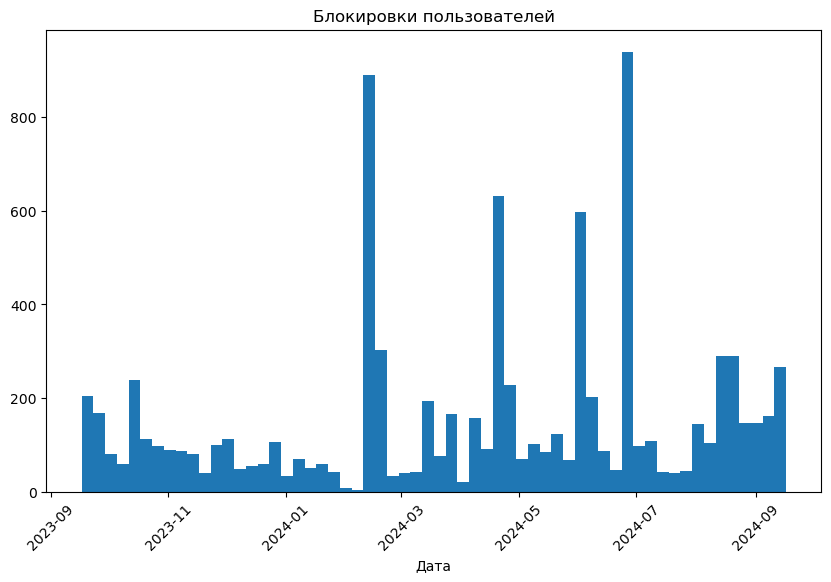

In [15]:
#строим гистограмму по датам
plt.figure(figsize=(10, 6))
plt.hist(df['date_block'], bins=60)
plt.title('Блокировки пользователей')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

Так можем увидеть основные наплывы фрода за год, выраженные в количестве уникальных пользователей. Что примечательно, с февраля по июль наплывов было больше и они были интенсивнее.

### Распределение фрода по валютам

Далее построим визуализацию распределения уникальных пользователей по валютам. Выделим условную десятку валют, остальные вынесем в раздел "другие".

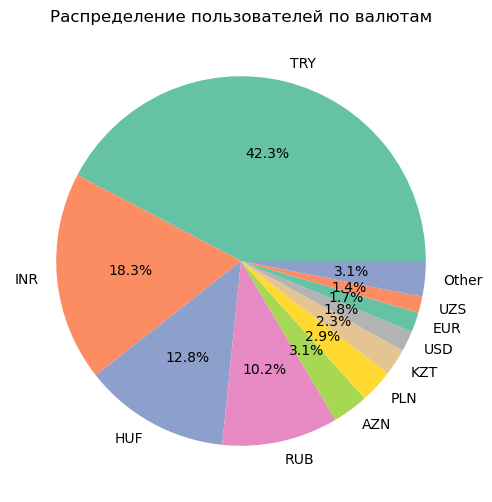

In [16]:
#посчитаем доли блокировок по валютам
users_by_code = df.groupby('code')['user_id'].nunique().reset_index()
users_by_code.columns = ['code', 'unique_user_count']
users_by_code['percentage'] = (users_by_code['unique_user_count'] / users_by_code['unique_user_count'].sum()) * 100

#выделим топ 10 валют и остальные поместим в раздел "другие"
users_by_code = users_by_code.sort_values('percentage', ascending=False).head(10)

#создадим новую строку
others = pd.DataFrame({
    'code': ['Other'],
    'unique_user_count': [df.groupby('code')['user_id'].nunique().sum() - users_by_code['unique_user_count'].sum()],
    'percentage': [100 - users_by_code['percentage'].sum()]
})

#объединим основной датасет с новой строкой
users_by_code = pd.concat([users_by_code, others], ignore_index=True)

#строим диаграмму
plt.figure(figsize=(6, 6))
colors = sns.color_palette('Set2')
plt.pie(users_by_code['unique_user_count'], labels=users_by_code['code'], colors=colors, autopct='%1.1f%%')
plt.title('Распределение пользователей по валютам')
plt.show()

График показывает следующее распределение уникальных пользователей по валютам: наиболее популярными оказались TRY (42,3%), INR (18,3%), HUF (12,8%), RUB (10,2%).

### Депозиты

#### Преобразования

Следующим шагом разберем данные уже не по уникальным айди пользователей, а по количеству и сумме пополнений. Результаты такого рассмотрения могут существенно отличаться от предыдущих, но они покажут реальное поведение пользователей. 

Аггрегируем данные для анализа. А для того, чтобы можно было сравнивать данные по депозитам между собой, конвертируем суммы пополнений из национальных валют в USD.

In [17]:
#количество пополнений
t1 = refill.groupby(['code', 'user_id', 'refill_sum'], as_index=False)['amount'].agg({'amount':'count'}).rename(columns={'amount':'amount_cnt'})

#средняя сумма пополнений
t2 = refill.groupby(['code', 'user_id', 'refill_sum'], as_index=False)['amount'].agg({'amount':'median'}).round(1).rename(columns={'amount':'amount_mean'})

#объединим и получим датасет, в котором можем рассмотреть каждого пользователя и валюту
refill_sorted = t1.merge(t2).sort_values(by='refill_sum', ascending=False)

#курсы валют
exchange_rates = {
    'UZS': 0.000078,
    'KZT': 0.0021, 
    'INR': 0.012, 
    'UAH': 0.024, 
    'RUB': 0.01, 
    'TRY': 0.029, 
    'HUF': 0.0028, 
    'NPR': 0.0075,
    'PLN': 0.26,
    'EUR': 1.11, 
    'BDT': 0.0084, 
    'PKR': 0.0036, 
    'KGS': 0.012, 
    'AZN': 0.59, 
    'CZK': 0.044, 
    'LKR': 0.0034, 
    'BRL': 0.18, 
    'CAD': 0.74,
    'MXN': 0.051, 
    'USD': 1, 
    'NOK': 0.094, 
    'BYN': 0.31, 
    'AED': 0.27
}

#функция для конвертации
def convert_to_usd(row):
    currency_code = row['code']
    if currency_code in exchange_rates:
        row['refill_sum_usd'] = round(row['refill_sum'] * exchange_rates[currency_code], 1)
        row['amount_mean_usd'] = round(row['amount_mean'] * exchange_rates[currency_code], 1)
    else:
        row['refill_sum_usd'] = None
        row['amount_mean_usd'] = None
    return row

refill_sorted = refill_sorted.apply(convert_to_usd, axis=1)

refill_sorted.head()

,code,user_id,refill_sum,amount_cnt,amount_mean,refill_sum_usd,amount_mean_usd
4941,UZS,97175175,542210556,483,600000.0,42292.4,46.8
4923,UZS,16596563,511507800,1247,160000.0,39897.6,12.5
4938,UZS,92504863,281060242,176,800004.5,21922.7,62.4
4929,UZS,38178819,234167500,1571,125000.0,18265.1,9.8
4955,UZS,133652335,113985000,58,650000.0,8890.8,50.7


Расшифровка данных:

- *code* - валюта
- *user_id* - айди пользователей
- *refill_sum* - сумма всех пополнений пользователя
- *amount_cnt* - количество пополнений пользователя
- *amount_mean* - средняя сумма пополнения пользователя
- *refill_sum_usd* - сумма всех пополнений пользователя в USD
- *amount_mean_usd* - средняя сумма пополнения пользователя в USD

Посчитаем описательные статистики.

In [18]:
refill_sorted[['amount_mean_usd', 'refill_sum_usd', 'amount_cnt']].describe()

,amount_mean_usd,refill_sum_usd,amount_cnt
count,5019.000000,5019.000000,5019.000000
mean,59.795158,4442.418928,99.661088
std,96.691957,17338.510583,312.354268
min,0.000000,0.500000,1.000000
25%,8.100000,47.550000,2.000000
50%,23.000000,319.000000,7.000000
75%,75.000000,1316.500000,40.000000
max,1665.000000,400747.200000,5328.000000


Исходя из того, как распределены данные, для их аггрегации будем рассчитывать медианы.

In [19]:
#создаем сводную таблицу, сгруппированную по валютам
refill_pivot = (refill_sorted.pivot_table(index='code', values=['refill_sum_usd', 'amount_mean_usd', 'amount_cnt'], 
                           aggfunc={'amount_cnt':'median', 'amount_mean_usd':'median', 'refill_sum_usd':'sum'})
     .reset_index()
)

refill_pivot

,code,amount_cnt,amount_mean_usd,refill_sum_usd
0,AED,2.0,1.90,3.8
1,AZN,3.0,59.00,457273.8
2,BDT,20.5,42.00,2586.8
3,BRL,1.0,18.00,23656.7
4,BYN,1.0,2.20,66.6
5,CAD,8.0,194.60,110388.2
6,CZK,3.5,18.70,53894.1
7,EUR,3.0,55.50,894373.0
8,HUF,9.0,13.60,78607.9
9,INR,26.0,36.00,14355957.3


#### Общая сумма депозитов

Построим визуализацию сумм депозитов игроков по валютам. Соотнесем это с ранее полученными данными по распределению заблокированных пользователей по валютам.

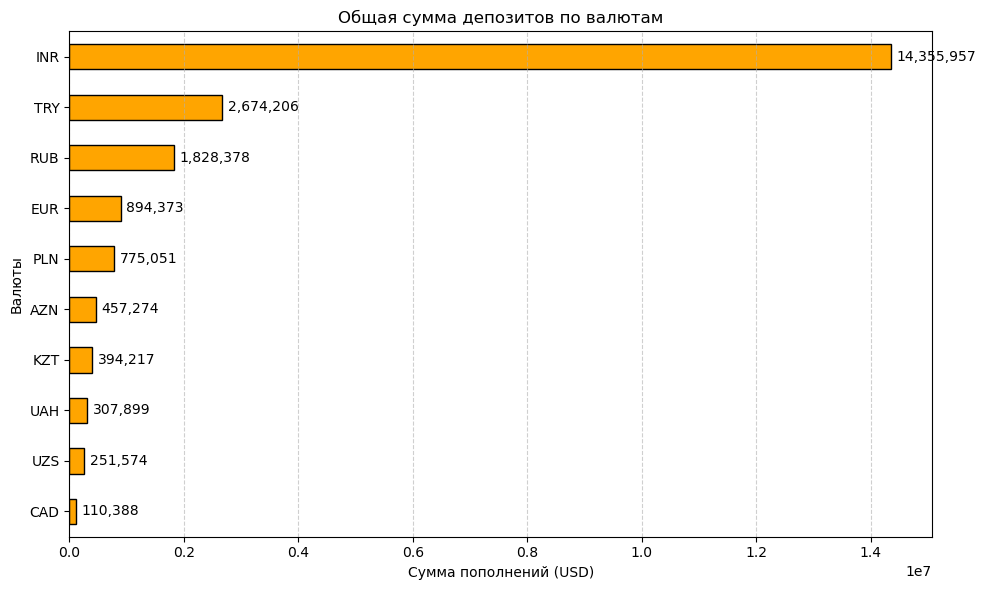

In [20]:
sorted_refill_sum = refill_pivot.sort_values(by='refill_sum_usd', ascending=False).head(10)

#создаем график
plt.figure(figsize=(10, 6))
ax = sorted_refill_sum.sort_values(by='refill_sum_usd', ascending=True).plot(
    y='refill_sum_usd', 
    x='code', 
    kind='barh', 
    color='orange', 
    edgecolor='black',
    legend=False,
    ax=plt.gca()
)

plt.title('Общая сумма депозитов по валютам')
plt.xlabel('Сумма пополнений (USD)')
plt.ylabel('Валюты')

#добавим подписи к столбцам
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}', 
                (p.get_width() + 100000, p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Наибольшая доля пополнений в валютах INR, TRY, RUB - в сумме более 19 млн долларов удачных депозитов, что в целом соотносится с тем, как уникальные заблокированные пользователи распределены по валютам: TRY (42,3%), INR (18,3%), RUB (10,2%). Что касается валюты HUF (12,8%), общая сумма пополнений не входит и в десятку, а количество блокированных пользователей относительно больше. Предположим, что это пустые мультиаккаунты - их много, но пополнений недостаточно для того, чтобы относить валюту в один ряд с рублями или лирами. Вероятно, на следующих этапах анализа увидим подробные детали этой аномалии.

Сделаем промежуточный вывод. По результатам рассмотрения данных наиболее фродовые валюты - **TRY, INR, RUB**. Здесь и абсолютное большинство уникальных пользователей - 70%, и депозитов в целом - более 19 млн долларов. 

#### Средние депозиты

Взглянем на соотношение средних сумм депозитов пользователей с числом их удачных попыток.

In [21]:
#сортируем данные
sorted_amount = refill_pivot.sort_values(by='amount_mean_usd', ascending=False)

sorted_amount

,code,amount_cnt,amount_mean_usd,refill_sum_usd
16,PKR,1.0,720.00,720.0
14,NOK,4.0,277.30,725.0
5,CAD,8.0,194.60,110388.2
12,LKR,6.0,85.00,559.1
1,AZN,3.0,59.00,457273.8
7,EUR,3.0,55.50,894373.0
2,BDT,20.5,42.00,2586.8
13,MXN,1.5,40.80,1217.9
21,USD,3.0,40.00,53508.0
9,INR,26.0,36.00,14355957.3


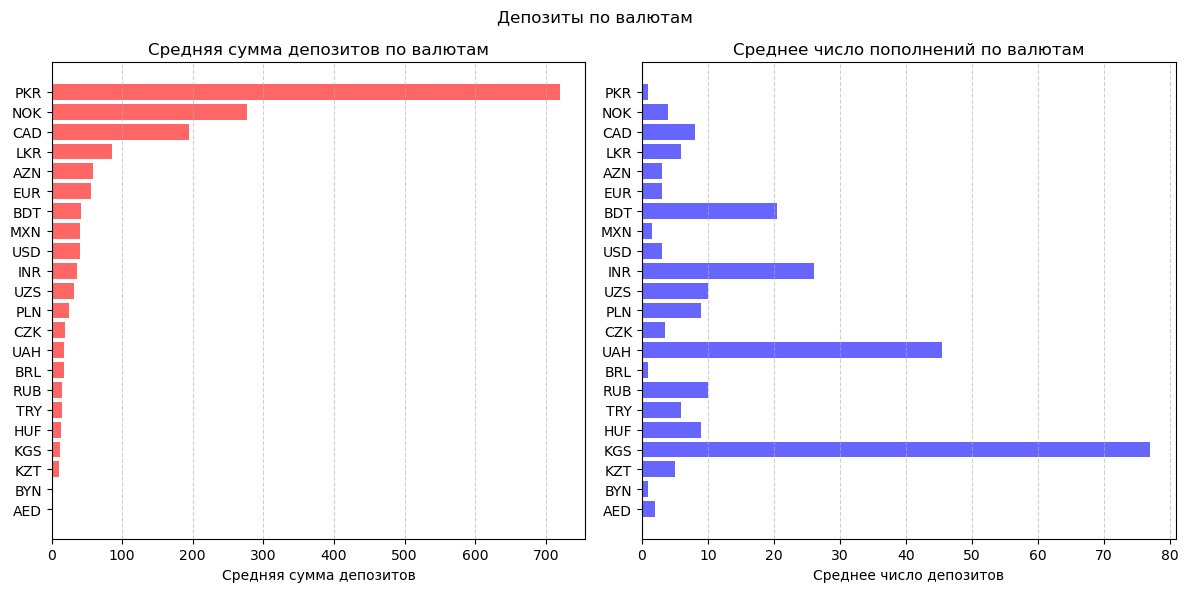

In [22]:
sorted_amount = refill_pivot.sort_values(by='amount_mean_usd', ascending=True)

#держим в голове, что у NPR критически много депозитов, с ней визуализация не будет корректно читаться
sorted_amount = sorted_amount[sorted_amount['code']!='NPR'] 

#строим графики
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.barh(sorted_amount['code'], sorted_amount['amount_mean_usd'], color='red', alpha=0.6)
ax1.set_xlabel('Средняя сумма депозитов')
ax1.set_title('Средняя сумма депозитов по валютам')
ax1.grid(axis='x', linestyle='--', alpha=0.6)

ax2.barh(sorted_amount['code'], sorted_amount['amount_cnt'], color='blue', alpha=0.6)
ax2.set_xlabel('Среднее число депозитов')
ax2.set_title('Среднее число пополнений по валютам')
ax2.grid(axis='x', linestyle='--', alpha=0.6)

plt.suptitle('Депозиты по валютам')

plt.tight_layout()
plt.show()

Для наиболее фродовых валют (INR, RUB, TRY) характерны некрупные средние суммы депозитов и большое количество попыток пополнить баланс. Например, для типичного игрока в RUB в среднем сумма депозита равняется 15 долларов, а пополняет баланс он примерно 10 раз до того, как получит блокировку за чарджи. Для клиента TRY схожие показатели: в среднем пополняет 14,5 долларов по 6-7 раз. А игроки INR совершают много пополнений на суммы в среднем 36 долларов, за счет чего и складывается наибольшая сумма всех депозитов игроков в этой валюте.

Есть и аномалии в этом плане: PKR и NOK, которые в среднем пополняются по несколько раз на невероятно крупные суммы (720 и 200 долларов), также и наоборот в валютах KGS и UAH, пополнявшие свой баланс 77 и 45 раз, но по 12 и 18 долларов соответственно. NPR же является абсолютной аномалией - 820 удачных пополнений на среднюю сумму 33,8 долларов. Пополнений в этих валютах много, суммы иногда больше, чем у самых фродовых валют, но так как доля этих валют ничтожно мала, то фокусироваться на них в рамках этого анализа не будем.

### Методы пополнений

Рассмотрим самые популярные валюты *INR, TRY, RUB* и определим характерные методы пополнения для них. Посчитаем доли пользователей для каждого метода и найдем сколько пополнялось депозитов в долларах. Кроме того, найдем, сколько методов пополнения используют игроки в каждой валюте.

#### Число методов

Описательная статистика распределения количества методов пополнения для каждого клиента поможет нам взглянуть на то, как основная масса фродеров пополняется в разных валютах.

In [23]:
#создадим три датасета с числом уникальных методов для каждого игрока в валюте
d1 = (refill[refill['code'] == 'RUB'].groupby(['user_id'], as_index=False)
      .agg({'provider_method': 'nunique'}))

d2 = (refill[refill['code'] == 'TRY'].groupby(['user_id'], as_index=False)
      .agg({'provider_method': 'nunique'}))

d3 = (refill[refill['code'] == 'INR'].groupby(['user_id'], as_index=False)
      .agg({'provider_method': 'nunique'}))

d1.rename(columns={'provider_method': 'provider_methods_RUB'}, inplace=True)
d2.rename(columns={'provider_method': 'provider_methods_TRY'}, inplace=True)
d3.rename(columns={'provider_method': 'provider_methods_INR'}, inplace=True)

#объединим в один датасет и посмотрим на распределение
combined_d = d1.merge(d2, on='user_id', how='outer')
combined_d = combined_d.merge(d3, on='user_id', how='outer')

combined_d[['provider_methods_RUB', 'provider_methods_TRY', 'provider_methods_INR']].describe()

,provider_methods_RUB,provider_methods_TRY,provider_methods_INR
count,588.000000,1968.000000,1209.000000
mean,2.775510,1.935467,6.153846
std,3.385601,1.734955,6.231820
min,0.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000
50%,2.000000,1.000000,4.000000
75%,3.000000,2.000000,9.000000
max,29.000000,19.000000,37.000000


Для 75% игроков в валюте RUB характерно пополнение баланса 1-3 способами, но есть и те, кто использовал до 29 способов, всего 588 методов, что в несколько раз меньше, чем у TRY и INR. Для TRY характерно такое же поведение, когда 75% игроков пополняются 1-2 способами, и небольшая часть доходит до 19. Однако у TRY больше всего методов пополнения в общем - 1968, почти в четыре раза больше, чем у RUB и почти в два раза больше, чем у INR (1209). Отличается в этом ряду поведение игроков INR, 75% которых пополняют баланс до 9 способов, а максимальное количество - 37.

#### Популярные методы пополнения баланса

Теперь составим список популярных методов пополнения для каждой валюты. Здесь рассчитаем сумму всех депозитов по способам пополнения, а также доли пользователей и их количество.

##### Топ 15 способов пополнения для RUB

In [24]:
refill_rub = refill[refill['code']=='RUB']

refill_rub['amount_usd'] = round(refill_rub['amount'] * 0.01, 1)

refill_rub = (refill_rub.groupby(['provider_method'], as_index=False)
             .agg({'amount_usd':'sum',
                  'user_id':'nunique'})
             .sort_values(by='amount_usd', ascending=False)
             .reset_index(drop=True))

#посчитаем процент игроков для каждого метода
refill_rub['user_percentage'] = round((refill_rub['user_id'] / refill_rub['user_id'].sum()) * 100, 1)

refill_rub.head(15)

,provider_method,amount_usd,user_id,user_percentage
0,PAYMENT_PROVIDER_COREFY_TYPE_MIR,713093.7,447,27.4
1,PAYMENT_PROVIDER_COREFY_TYPE_VISA,220535.2,133,8.1
2,PAYMENT_PROVIDER_KIBERPAY_TYPE_KIBERPAY_P2P,219241.1,134,8.2
3,PAYMENT_PROVIDER_COREFY_TYPE_MASTERCARD,198027.4,122,7.5
4,PAYMENT_PROVIDER_MAJORPAY_TYPE_SBP,125079.5,52,3.2
5,PAYMENT_PROVIDER_MAJORPAY_TYPE_P2P,33305.5,35,2.1
6,PAYMENT_PROVIDER_OCTOPAY_TYPE_CREDIT_CARD_OCTO...,26196.0,31,1.9
7,PAYMENT_PROVIDER_PIMPAY_TYPE_VISA,24506.6,20,1.2
8,PAYMENT_PROVIDER_EXPAY_TYPE_EXPAY_P2P_GREENBACK,23208.1,11,0.7
9,PAYMENT_PROVIDER_PIMPAY_TYPE_MASTERCARD,22389.2,20,1.2


Топ 15 методов пополнения по сумме всех пополнений возглавляет PAYMENT_PROVIDER_COREFY_TYPE_MIR - 713,093 долларов. Им пользуется 27,4% всех игроков в валюте RUB. Также в список вошли методы пополнения баланса с различных карт, криптокошельков и п2п. Лидерство остается за карточными методами.

##### Топ 15 способов пополнения для TRY

In [25]:
refill_try = refill[refill['code']=='TRY']

refill_try['amount_usd'] = round(refill_try['amount'] * 0.029, 1)

refill_try = (refill_try.groupby(['provider_method'], as_index=False)
             .agg({'amount_usd':'sum',
                  'user_id':'nunique'})
             .sort_values(by='amount_usd', ascending=False)
             .reset_index(drop=True))

refill_try['user_percentage'] = round((refill_try['user_id'] / refill_try['user_id'].sum()) * 100, 1)

refill_try.head(15)

,provider_method,amount_usd,user_id,user_percentage
0,PAYMENT_PROVIDER_COREFY_TYPE_MASTERCARD,1005063.7,1585,41.6
1,PAYMENT_PROVIDER_PAYHERA_TYPE_PAPARA,540332.4,276,7.2
2,PAYMENT_PROVIDER_FIXTURKA_TYPE_PAYFIX,374352.6,225,5.9
3,PAYMENT_PROVIDER_JETPAYHUB_TYPE_BANK_TRANSFER,338271.4,288,7.6
4,PAYMENT_PROVIDER_COREFY_TYPE_VISA,185552.8,282,7.4
5,PAYMENT_PROVIDER_INSTAPAYS_TYPE_MASTERCARD,48241.5,304,8.0
6,PAYMENT_PROVIDER_OPTIPAY_TYPE_HAVALE,47058.8,138,3.6
7,PAYMENT_PROVIDER_LUQAPAY_TYPE_INSTANT_QR,25760.0,20,0.5
8,PAYMENT_PROVIDER_INSTAPAYS_TYPE_VISA,25075.6,159,4.2
9,PAYMENT_PROVIDER_BIRPAY_GATE_TYPE_BANKTOBANK__...,14729.4,48,1.3


Для турецких лир способ PAYMENT_PROVIDER_COREFY_TYPE_MASTERCARD является основным методом по сумме пополнений - 1,005,063 долларов, им пользуется 41,6% - почти половина всех клиентов в валюте TRY. В меньшей мере фродеры пополняются местными способами PAYMENT_PROVIDER_PAYHERA_TYPE_PAPARA (7,2%), PAYMENT_PROVIDER_FIXTURKA_TYPE_PAYFIX (5,9%), PAYMENT_PROVIDER_JETPAYHUB_TYPE_BANK_TRANSFER (7,6%). В целом, в списке популярны как местные кошельки, так и карточные методы пополнения, а криптокошельки в топ не вошли.

##### Топ 15 способов пополнения для INR

In [26]:
refill_inr = refill[refill['code']=='INR']

refill_inr['amount_usd'] = round(refill_inr['amount'] * 0.012, 1)

refill_inr = (refill_inr.groupby(['provider_method'], as_index=False)
             .agg({'amount_usd':'sum',
                  'user_id':'nunique'})
             .sort_values(by='amount_usd', ascending=False)
             .reset_index(drop=True))

refill_inr['user_percentage'] = round((refill_inr['user_id'] / refill_inr['user_id'].sum()) * 100, 1)

refill_inr.head(15)

,provider_method,amount_usd,user_id,user_percentage
0,PAYMENT_PROVIDER_BIRPAY_GATE_TYPE_UPI_BIRPAY,1817594.5,581,7.8
1,PAYMENT_PROVIDER_BIRPAY_GATE_TYPE_PAY_TM_BIRPAY,1761917.3,521,7.0
2,PAYMENT_PROVIDER_BIRPAY_GATE_TYPE_PHONEPE_BIRPAY,1659637.9,639,8.6
3,PAYMENT_PROVIDER_ALYCEPAY_TYPE_CHECKOUT,1608937.9,404,5.4
4,PAYMENT_PROVIDER_ALYCEPAY_TYPE_CHECKOUT_4,1371507.5,417,5.6
5,PAYMENT_PROVIDER_BIRPAY_GATE_TYPE_GPAY_BIRPAY,771818.8,495,6.7
6,PAYMENT_PROVIDER_COREFY_TYPE_VISA,580955.6,28,0.4
7,PAYMENT_PROVIDER_ALYCEPAY_TYPE_UPI_AUTOMATIC_2,328556.3,242,3.3
8,PAYMENT_PROVIDER_EPIQCASH_TYPE_EPIQCASH_UPI,266317.4,219,2.9
9,PAYMENT_PROVIDER_ALYCEPAY_TYPE_UPI_AUTOMATIC_1,262783.8,223,3.0


Среди способов пополнения баланса в INR, выделяющихся лидеров нет. Так как ранее выяснилось, что для этой валюты большинство клиентов в среднем используют до 9 способов пополнения, ожидаемы примерно одинаковые позиции топа по сумме пополнений и по долям игроков. Пятерка методов пополнений отражает практически равные суммы депозитов от 1,3 млн до 1,8 млн долларов. Клиенты пользуются этими методами в равных пропорциях 5-8% от числа всех фродеров в INR.

## Выводы

В ходе данного исследования были обнаружены валюты, с которых шел основной фрод чарджей за период с 2023-09-16 по 2024-09-16: TRY, INR, RUB. На эти валюты пришлось более 70% числа уникальных фродовых аккаунтов и более 19 млн долларов пополнений их балансов.

Для валют были рассчитаны средние суммы депозитов и количества пополнений, что помогло составить портрет типичного клиента для определенной валюты.

Для основных фродовых валют были найдены и детально рассмотрены списки топ способов пополнений балансов и провайдеров по сумме пополнений, и приведены число и доли игроков, пользующихся тем или иным провайдером.

Найденная информация может быть использована для следующей проверки валют и провайдеров, через которые идет основной поток фрода чарджбек.